# Methods Notebook: Extracting Call Samples for KMeans Clustering

## Imports Section:

In [1]:
import numpy as np
import pandas as pd
import random
import scipy
from scipy import stats
import datetime as dt
import dask.dataframe as dd

import pytz

import re
import suncalc
import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS, FREQ_GROUPS, SEATTLE_LATITUDE, SEATTLE_LONGITUDE
import bout.assembly as bt
import bout.clustering as bt_clustering
import bout.plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as dh

import calls.compute_features as cf
import calls.call_extraction as cextract

from cli import get_file_paths
import plot
import pipeline

['/Users/adityakrishna/duty-cycle-investigation/daily_notebook', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python311.zip', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/lib-dynload', '', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages', '../src', '../src', '../src', '../src/bout', '../src', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src/bout', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src']


In [80]:
def plot_dets_over_audio_seg(audio_features, spec_features, plot_dets, data_params):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')

    UBNA_tz = pytz.timezone('US/Pacific')
    UTC_tz = pytz.timezone('UTC')

    file_dt_UTC = UTC_tz.localize(file_dt)
    file_dt_PST = file_dt_UTC.astimezone(UBNA_tz)
    file_title = f'{file_dt_PST.date()} {file_dt_PST.time()} PST'

    on = int(data_params['cur_dc_tag'].split('of')[0])
    total = int(data_params['cur_dc_tag'].split('of')[1])

    plt.figure(figsize=audio_features['figsize'])
    plt.rcParams.update({'font.size': 24})
    plt.title(f"Duty-cycle scheme: {on}min ON every {total}min", fontsize=22)
    plt.title(f"Audiomoth file recorded at {file_title}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmax=0, vmin=spec_features['vmin'])

    orange_patch = patches.Patch(facecolor='orange', edgecolor='k', label='High-frequency calls')
    cyan_patch = patches.Patch(facecolor='cyan', edgecolor='k', label='Low-frequency calls')

    legend_patches = [orange_patch, cyan_patch]
    ax = plt.gca()
    # plot_recording_periods(ax, audio_features, data_params)
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor=FREQUENCY_COLOR_MAPPINGS[row['freq_group']], facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)


    # windows_PST = pd.date_range(file_dt_PST+pd.Timedelta(seconds=start), file_dt_PST+pd.Timedelta(seconds=start)+pd.Timedelta(seconds=duration), freq=f'{duration/5}s', inclusive='both')

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.linspace(start, (start+duration), 11), rotation=30)
    # times = [' ']*len(windows_PST.strftime('%-M'))
    # plt.xticks(ticks=np.linspace(0, duration*(fs/2), len(windows_PST)), labels=windows_PST.strftime('%M:%S'), color='k')
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (seconds)")
    # plt.gcf().autofmt_xdate()
    # plt.ylim(0, 96/125)
    # cbar = plt.colorbar()
    # cbar.ax.tick_params(labelsize=16)
    plt.legend(handles=legend_patches, fontsize=20, ncol=1, loc='upper right')

    plt.tight_layout()
    plt.show()

def plot_recording_periods(ax, audio_features, data_params):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    for window_start in window_starts:
        if (window_start <= start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=data_params['recording_alpha'])
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=data_params['recording_alpha'])
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=data_params['recording_alpha'])
            ax.add_patch(rect)

In [5]:
cycle_lengths = [10]
percent_ons = [1/2]
specific_dc_tag = "30of30"

data_params = dict()
data_params["year"] = '2022'
data_params['use_thresholds'] = True
data_params['use_kmeans'] = False
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['bin_size'] = '30'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params["save_activity_grid"] = False
pipeline_params["save_presence_grid"] = False
pipeline_params["save_dc_night_comparisons"] = False
pipeline_params["save_activity_dc_comparisons"] = True
pipeline_params["save_presence_dc_comparisons"] = True
pipeline_params["show_plots"] = True
pipeline_params["show_PST"] = False

site_key = 'Telephone'
type_key = ''
print(site_key, type_key)

data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = type_key
data_params["detector_tag"] = 'kd'

file_paths = get_file_paths(data_params)
file_paths

Telephone 


{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Telephone',
 'detector': 'kd',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_detector_summaries/Telephone',
 'SITE_classes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Telephone',
 'SITE_classes_file': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Telephone/2022_kdTelephone_call_classes.csv',
 'detector_TYPE_SITE_YEAR': 'kd__Telephone_2022_thresh',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_detector_summaries/Telephone/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_kddets_Telephone_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_kdbouts_Telephone_summary',
 'dc_inds_TYPE_SITE_summary': 'dc_kdinds_Telephone_summary',
 'dc_callrate_TYPE_SITE_summary': 'dc_kdcallrate_Telephone_summary',
 'cont_callrate_TYPE_SITE_summary': 'cont_kdcallrate_Telephone_summary',
 'dc_bt

In [6]:
init_location_sum = dh.assemble_initial_location_summary(file_paths) 
init_location_sum.reset_index(inplace=True)
init_location_sum.rename({'index':'index_in_file'}, axis='columns', inplace=True)
init_location_sum

,index_in_file,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,file_name,input_dir,input_file,mean_freq,class,TOP1DIST,TOP2MATCH,TOP2DIST,TOP3MATCH,TOP3DIST,file_group
0,0,2022-07-23 04:28:55.573486,2022-07-23 04:28:55.573486,2022-07-23 04:28:55.574510,1735.573486,1735.574510,45977.012,49691.359,20220723_040000.WAV,/mnt/ubna_data_01_mir/recover-20220725/UBNA_010,/mnt/ubna_data_01_mir/recover-20220725/UBNA_01...,46863.023,nocluster,0,NaN,0,NaN,0,20220723_040000.WAV
1,1,2022-07-23 04:28:55.749146,2022-07-23 04:28:55.749146,2022-07-23 04:28:55.750239,1735.749146,1735.750239,45977.012,49691.359,20220723_040000.WAV,/mnt/ubna_data_01_mir/recover-20220725/UBNA_010,/mnt/ubna_data_01_mir/recover-20220725/UBNA_01...,47579.977,nocluster,0,NaN,0,NaN,0,20220723_040000.WAV
2,2,2022-07-23 04:28:56.108154,2022-07-23 04:28:56.108154,2022-07-23 04:28:56.110226,1736.108154,1736.110226,44200.242,50332.383,20220723_040000.WAV,/mnt/ubna_data_01_mir/recover-20220725/UBNA_010,/mnt/ubna_data_01_mir/recover-20220725/UBNA_01...,46337.926,nocluster,0,NaN,0,NaN,0,20220723_040000.WAV
3,3,2022-07-23 04:28:56.201660,2022-07-23 04:28:56.201660,2022-07-23 04:28:56.203014,1736.201660,1736.203014,45454.547,50316.453,20220723_040000.WAV,/mnt/ubna_data_01_mir/recover-20220725/UBNA_010,/mnt/ubna_data_01_mir/recover-20220725/UBNA_01...,47274.305,nocluster,0,NaN,0,NaN,0,20220723_040000.WAV
4,4,2022-07-23 04:28:56.290405,2022-07-23 04:28:56.290405,2022-07-23 04:28:56.292283,1736.290405,1736.292283,43055.555,50641.023,20220723_040000.WAV,/mnt/ubna_data_01_mir/recover-20220725/UBNA_010,/mnt/ubna_data_01_mir/recover-20220725/UBNA_01...,46849.590,nocluster,0,NaN,0,NaN,0,20220723_040000.WAV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782224,229,2022-10-17 13:45:47.672363,2022-10-17 13:45:47.672363,2022-10-17 13:45:47.673621,947.672363,947.673621,51615.051,58823.531,20221017_133000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_007,/mnt/ubna_data_02_mir/recover-20221017/UBNA_00...,54069.297,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV
782225,230,2022-10-17 13:45:47.940063,2022-10-17 13:45:47.940063,2022-10-17 13:45:47.941111,947.940063,947.941111,51282.051,58836.254,20221017_133000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_007,/mnt/ubna_data_02_mir/recover-20221017/UBNA_00...,53417.879,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV
782226,231,2022-10-17 13:45:48.615417,2022-10-17 13:45:48.615417,2022-10-17 13:45:48.616517,948.615417,948.616517,51956.812,67231.641,20221017_133000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_007,/mnt/ubna_data_02_mir/recover-20221017/UBNA_00...,58201.324,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV
782227,232,2022-10-17 13:45:48.689087,2022-10-17 13:45:48.689087,2022-10-17 13:45:48.690417,948.689087,948.690417,50316.453,65079.363,20221017_133000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_007,/mnt/ubna_data_02_mir/recover-20221017/UBNA_00...,54119.754,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV


In [7]:
def add_frequency_group_to_file_dets(file_dets, location_classes):
    print(file_dets.name)
    file_classes = location_classes[pd.to_datetime(location_classes['file_name'], 
                                                   format='%Y%m%d_%H%M%S.WAV', exact=False)==file_dets.name].copy()

    file_dets.insert(0, 'index_in_summary', file_dets.index)
    file_dets.set_index('index_in_file', inplace=True)

    classified = file_classes['KMEANS_CLASSES']!=''
    file_classes.loc[classified, 'peak_frequency'] = file_classes.loc[classified, 'peak_frequency'].astype('float64')

    file_dets.insert(0, 'peak_frequency', [np.NaN]*len(file_dets))
    file_dets.loc[file_classes['index_in_file'], 'freq_group'] = file_classes['KMEANS_CLASSES'].values
    file_dets.loc[file_classes['index_in_file'], 'peak_frequency'] = file_classes['peak_frequency'].values

    classified_dets = (file_dets['freq_group']!='')
    assert (file_dets.loc[classified_dets, 'peak_frequency'] > (file_dets.loc[classified_dets, 'low_freq'])-7000).all()
    assert (file_dets.loc[classified_dets, 'peak_frequency'] < (file_dets.loc[classified_dets, 'high_freq'])+7000).all()

    return file_dets

def add_frequency_groups_to_summary_using_kmeans(location_df, file_paths, data_params, save=True):
    location_df.insert(0, 'freq_group', '')
    location_classes = pd.read_csv(Path(file_paths['SITE_classes_file']), index_col=0)
    location_df.insert(0, 'input_file_dt', pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S.WAV', exact=False))
    location_df_grouped = location_df.groupby('input_file_dt', group_keys=True)

    location_df_classified = location_df_grouped.apply(lambda x: add_frequency_group_to_file_dets(x, location_classes))

    location_df_only_classified = location_df_classified.loc[location_df_classified['freq_group']!='']
    location_df_only_classified = location_df_only_classified.droplevel(level=0)
    location_df_only_classified = location_df_only_classified.reset_index()

    if data_params['type_tag'] != '':
        location_df_only_classified = location_df_only_classified.loc[location_df_only_classified['freq_group']==data_params['type_tag']]

    if save:
        location_df_only_classified.to_csv(f'{file_paths["SITE_folder"]}/{file_paths["detector_TYPE_SITE_YEAR"]}.csv')

    return location_df_only_classified

In [8]:
file_paths['SITE_classes_file']

'/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Telephone/2022_kdTelephone_call_classes.csv'

In [9]:
location_classes = pd.read_csv(Path(file_paths['SITE_classes_file']), index_col=0)
location_classes

,index,KMEANS_CLASSES,peak_frequency,SNR,index_in_file,index_in_summary,file_name,sampling_rate
0,0,HF,47040.0,17.036075,0,0,20220723_040000.WAV,250000
1,1,HF,47040.0,15.886007,1,1,20220723_040000.WAV,250000
2,2,HF,45120.0,19.350794,2,2,20220723_040000.WAV,250000
3,3,HF,47040.0,15.931615,3,3,20220723_040000.WAV,250000
4,4,HF,47040.0,20.159453,4,4,20220723_040000.WAV,250000
...,...,...,...,...,...,...,...,...
773096,229,HF,52800.0,29.662423,229,782224,20221017_133000.WAV,192000
773097,230,HF,52800.0,22.125354,230,782225,20221017_133000.WAV,192000
773098,231,HF,52800.0,23.385766,231,782226,20221017_133000.WAV,192000
773099,232,HF,51840.0,30.128313,232,782227,20221017_133000.WAV,192000


In [13]:
thresh_location_df = init_location_sum.copy()
thresh_location_df.insert(0, 'freq_group', '')
location_classes = pd.read_csv(Path(file_paths['SITE_classes_file']), index_col=0)
thresh_location_df.insert(0, 'input_file_dt', pd.to_datetime(thresh_location_df['input_file'], format='%Y%m%d_%H%M%S.WAV', exact=False))
location_df_grouped = thresh_location_df.groupby('input_file_dt', group_keys=True)

location_df_classified = location_df_grouped.apply(lambda x: add_frequency_group_to_file_dets(x, location_classes))

2022-07-23 04:00:00
2022-07-23 04:30:00
2022-07-23 05:00:00
2022-07-23 05:30:00
2022-07-23 06:00:00
2022-07-23 06:30:00
2022-07-23 07:00:00
2022-07-23 07:30:00
2022-07-23 08:00:00
2022-07-23 08:30:00
2022-07-23 09:00:00
2022-07-23 09:30:00
2022-07-23 10:00:00
2022-07-23 10:30:00
2022-07-23 11:00:00
2022-07-23 11:30:00
2022-07-23 12:00:00
2022-07-24 04:30:00
2022-07-24 05:00:00
2022-07-24 05:30:00
2022-07-24 06:00:00
2022-07-24 06:30:00
2022-07-24 07:00:00
2022-07-24 07:30:00
2022-07-24 08:00:00
2022-07-24 08:30:00
2022-07-24 09:00:00
2022-07-24 09:30:00
2022-07-24 10:00:00
2022-07-24 10:30:00
2022-07-24 11:00:00
2022-07-24 11:30:00
2022-07-24 12:00:00
2022-07-24 13:00:00
2022-07-25 01:30:00
2022-07-25 04:00:00
2022-07-25 04:30:00
2022-07-25 05:00:00
2022-07-25 05:30:00
2022-07-25 06:00:00
2022-07-25 06:30:00
2022-07-25 07:00:00
2022-07-25 07:30:00
2022-07-25 08:00:00
2022-07-25 08:30:00
2022-07-25 09:00:00
2022-07-25 09:30:00
2022-07-25 10:00:00
2022-07-25 10:30:00
2022-07-25 11:00:00


AssertionError: 

## There is an ERROR at file: 20220820_053000.WAV from Telephone Field

In [22]:
file_dets = thresh_location_df[thresh_location_df['file_name']=='20220820_053000.WAV']
file_dets

,input_file_dt,freq_group,index_in_file,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,...,input_dir,input_file,mean_freq,class,TOP1DIST,TOP2MATCH,TOP2DIST,TOP3MATCH,TOP3DIST,file_group
86754,2022-08-20 05:30:00,,0,2022-08-20 05:30:00.662079,2022-08-20 05:30:00.662079,2022-08-20 05:30:00.663658,0.662079,0.663658,38655.461,43244.508,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,40531.383,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
86755,2022-08-20 05:30:00,,1,2022-08-20 05:30:18.012859,2022-08-20 05:30:18.012859,2022-08-20 05:30:18.015092,18.012859,18.015092,39409.824,43956.043,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,41206.539,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
86756,2022-08-20 05:30:00,,2,2022-08-20 05:30:26.818005,2022-08-20 05:30:26.818005,2022-08-20 05:30:26.819550,26.818005,26.819550,39809.863,43244.508,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,41413.445,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
86757,2022-08-20 05:30:00,,3,2022-08-20 05:30:27.230772,2022-08-20 05:30:27.230772,2022-08-20 05:30:27.233752,27.230772,27.233752,38475.766,48199.766,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,42953.285,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
86758,2022-08-20 05:30:00,,4,2022-08-20 05:30:39.532795,2022-08-20 05:30:39.532795,2022-08-20 05:30:39.535016,39.532795,39.535016,41671.188,46798.031,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,43222.848,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87853,2022-08-20 05:30:00,,1099,2022-08-20 05:59:33.406738,2022-08-20 05:59:33.406738,2022-08-20 05:59:33.408350,1773.406738,1773.408350,50000.000,55946.789,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,52117.035,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
87854,2022-08-20 05:30:00,,1100,2022-08-20 05:59:35.449097,2022-08-20 05:59:35.449097,2022-08-20 05:59:35.450521,1775.449097,1775.450521,50316.453,56740.441,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,53368.480,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
87855,2022-08-20 05:30:00,,1101,2022-08-20 05:59:36.288452,2022-08-20 05:59:36.288452,2022-08-20 05:59:36.291108,1776.288452,1776.291108,49382.715,57983.195,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,52710.113,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
87856,2022-08-20 05:30:00,,1102,2022-08-20 05:59:36.489258,2022-08-20 05:59:36.489258,2022-08-20 05:59:36.490494,1776.489258,1776.490494,50000.000,54054.055,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,51793.766,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV


In [23]:
file_classes = location_classes[location_classes['file_name']=='20220820_053000.WAV']
file_classes

,index,KMEANS_CLASSES,peak_frequency,SNR,index_in_file,index_in_summary,file_name,sampling_rate
86168,0,HF,41280.0,17.051753,0,86754,20220820_053000.WAV,192000
86169,1,HF,40320.0,17.077649,1,86755,20220820_053000.WAV,192000
86170,2,HF,40320.0,13.638759,2,86756,20220820_053000.WAV,192000
86171,3,HF,41280.0,19.358908,3,86757,20220820_053000.WAV,192000
86172,4,HF,42240.0,17.005776,4,86758,20220820_053000.WAV,192000
...,...,...,...,...,...,...,...,...
87266,1099,HF,52800.0,17.531558,1099,87853,20220820_053000.WAV,192000
87267,1100,HF,51840.0,17.330927,1100,87854,20220820_053000.WAV,192000
87268,1101,HF,52800.0,14.935168,1101,87855,20220820_053000.WAV,192000
87269,1102,HF,51840.0,16.505780,1102,87856,20220820_053000.WAV,192000


In [24]:
file_dets.insert(0, 'index_in_summary', file_dets.index)
file_dets.set_index('index_in_file', inplace=True)
file_dets

,index_in_summary,input_file_dt,freq_group,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,...,input_dir,input_file,mean_freq,class,TOP1DIST,TOP2MATCH,TOP2DIST,TOP3MATCH,TOP3DIST,file_group
index_in_file,,,,,,,,,,,,,,,,,,,,,
0,86754,2022-08-20 05:30:00,,2022-08-20 05:30:00.662079,2022-08-20 05:30:00.662079,2022-08-20 05:30:00.663658,0.662079,0.663658,38655.461,43244.508,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,40531.383,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
1,86755,2022-08-20 05:30:00,,2022-08-20 05:30:18.012859,2022-08-20 05:30:18.012859,2022-08-20 05:30:18.015092,18.012859,18.015092,39409.824,43956.043,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,41206.539,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
2,86756,2022-08-20 05:30:00,,2022-08-20 05:30:26.818005,2022-08-20 05:30:26.818005,2022-08-20 05:30:26.819550,26.818005,26.819550,39809.863,43244.508,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,41413.445,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
3,86757,2022-08-20 05:30:00,,2022-08-20 05:30:27.230772,2022-08-20 05:30:27.230772,2022-08-20 05:30:27.233752,27.230772,27.233752,38475.766,48199.766,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,42953.285,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
4,86758,2022-08-20 05:30:00,,2022-08-20 05:30:39.532795,2022-08-20 05:30:39.532795,2022-08-20 05:30:39.535016,39.532795,39.535016,41671.188,46798.031,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,43222.848,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,87853,2022-08-20 05:30:00,,2022-08-20 05:59:33.406738,2022-08-20 05:59:33.406738,2022-08-20 05:59:33.408350,1773.406738,1773.408350,50000.000,55946.789,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,52117.035,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
1100,87854,2022-08-20 05:30:00,,2022-08-20 05:59:35.449097,2022-08-20 05:59:35.449097,2022-08-20 05:59:35.450521,1775.449097,1775.450521,50316.453,56740.441,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,53368.480,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
1101,87855,2022-08-20 05:30:00,,2022-08-20 05:59:36.288452,2022-08-20 05:59:36.288452,2022-08-20 05:59:36.291108,1776.288452,1776.291108,49382.715,57983.195,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,52710.113,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV


In [41]:
file_classes = file_classes.astype({'peak_frequency':float})
file_classes

,index,KMEANS_CLASSES,peak_frequency,SNR,index_in_file,index_in_summary,file_name,sampling_rate
86168,0,HF,41280.0,17.051753,0,86754,20220820_053000.WAV,192000
86169,1,HF,40320.0,17.077649,1,86755,20220820_053000.WAV,192000
86170,2,HF,40320.0,13.638759,2,86756,20220820_053000.WAV,192000
86171,3,HF,41280.0,19.358908,3,86757,20220820_053000.WAV,192000
86172,4,HF,42240.0,17.005776,4,86758,20220820_053000.WAV,192000
...,...,...,...,...,...,...,...,...
87266,1099,HF,52800.0,17.531558,1099,87853,20220820_053000.WAV,192000
87267,1100,HF,51840.0,17.330927,1100,87854,20220820_053000.WAV,192000
87268,1101,HF,52800.0,14.935168,1101,87855,20220820_053000.WAV,192000
87269,1102,HF,51840.0,16.505780,1102,87856,20220820_053000.WAV,192000


In [42]:
file_dets.insert(0, 'peak_frequency', [np.NaN]*len(file_dets))
file_dets.loc[file_classes['index_in_file'], 'freq_group'] = file_classes['KMEANS_CLASSES'].values
file_dets.loc[file_classes['index_in_file'], 'peak_frequency'] = file_classes['peak_frequency'].values
file_dets

,peak_frequency,index_in_summary,input_file_dt,freq_group,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,...,input_dir,input_file,mean_freq,class,TOP1DIST,TOP2MATCH,TOP2DIST,TOP3MATCH,TOP3DIST,file_group
index_in_file,,,,,,,,,,,,,,,,,,,,,
0,41280.0,86754,2022-08-20 05:30:00,HF,2022-08-20 05:30:00.662079,2022-08-20 05:30:00.662079,2022-08-20 05:30:00.663658,0.662079,0.663658,38655.461,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,40531.383,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
1,40320.0,86755,2022-08-20 05:30:00,HF,2022-08-20 05:30:18.012859,2022-08-20 05:30:18.012859,2022-08-20 05:30:18.015092,18.012859,18.015092,39409.824,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,41206.539,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
2,40320.0,86756,2022-08-20 05:30:00,HF,2022-08-20 05:30:26.818005,2022-08-20 05:30:26.818005,2022-08-20 05:30:26.819550,26.818005,26.819550,39809.863,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,41413.445,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
3,41280.0,86757,2022-08-20 05:30:00,HF,2022-08-20 05:30:27.230772,2022-08-20 05:30:27.230772,2022-08-20 05:30:27.233752,27.230772,27.233752,38475.766,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,42953.285,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
4,42240.0,86758,2022-08-20 05:30:00,HF,2022-08-20 05:30:39.532795,2022-08-20 05:30:39.532795,2022-08-20 05:30:39.535016,39.532795,39.535016,41671.188,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,43222.848,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,52800.0,87853,2022-08-20 05:30:00,HF,2022-08-20 05:59:33.406738,2022-08-20 05:59:33.406738,2022-08-20 05:59:33.408350,1773.406738,1773.408350,50000.000,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,52117.035,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
1100,51840.0,87854,2022-08-20 05:30:00,HF,2022-08-20 05:59:35.449097,2022-08-20 05:59:35.449097,2022-08-20 05:59:35.450521,1775.449097,1775.450521,50316.453,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,53368.480,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV
1101,52800.0,87855,2022-08-20 05:30:00,HF,2022-08-20 05:59:36.288452,2022-08-20 05:59:36.288452,2022-08-20 05:59:36.291108,1776.288452,1776.291108,49382.715,...,/mnt/ubna_data_01_mir/recover-20220822/UBNA_001,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...,52710.113,nocluster,0,NaN,0,NaN,0,20220820_053000.WAV


In [44]:
file_dets.iloc[:,:11]

,peak_frequency,index_in_summary,input_file_dt,freq_group,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq
index_in_file,,,,,,,,,,,
0,41280.0,86754,2022-08-20 05:30:00,HF,2022-08-20 05:30:00.662079,2022-08-20 05:30:00.662079,2022-08-20 05:30:00.663658,0.662079,0.663658,38655.461,43244.508
1,40320.0,86755,2022-08-20 05:30:00,HF,2022-08-20 05:30:18.012859,2022-08-20 05:30:18.012859,2022-08-20 05:30:18.015092,18.012859,18.015092,39409.824,43956.043
2,40320.0,86756,2022-08-20 05:30:00,HF,2022-08-20 05:30:26.818005,2022-08-20 05:30:26.818005,2022-08-20 05:30:26.819550,26.818005,26.819550,39809.863,43244.508
3,41280.0,86757,2022-08-20 05:30:00,HF,2022-08-20 05:30:27.230772,2022-08-20 05:30:27.230772,2022-08-20 05:30:27.233752,27.230772,27.233752,38475.766,48199.766
4,42240.0,86758,2022-08-20 05:30:00,HF,2022-08-20 05:30:39.532795,2022-08-20 05:30:39.532795,2022-08-20 05:30:39.535016,39.532795,39.535016,41671.188,46798.031
...,...,...,...,...,...,...,...,...,...,...,...
1099,52800.0,87853,2022-08-20 05:30:00,HF,2022-08-20 05:59:33.406738,2022-08-20 05:59:33.406738,2022-08-20 05:59:33.408350,1773.406738,1773.408350,50000.000,55946.789
1100,51840.0,87854,2022-08-20 05:30:00,HF,2022-08-20 05:59:35.449097,2022-08-20 05:59:35.449097,2022-08-20 05:59:35.450521,1775.449097,1775.450521,50316.453,56740.441
1101,52800.0,87855,2022-08-20 05:30:00,HF,2022-08-20 05:59:36.288452,2022-08-20 05:59:36.288452,2022-08-20 05:59:36.291108,1776.288452,1776.291108,49382.715,57983.195


In [46]:
classified_dets = (file_dets['freq_group']!='')
valid_low_freq_inds = file_dets.loc[classified_dets, 'peak_frequency'] > ((file_dets.loc[classified_dets, 'low_freq'])-7000)
valid_low_freq_inds

index_in_file
0       True
1       True
2       True
3       True
4       True
        ... 
1099    True
1100    True
1101    True
1102    True
1103    True
Length: 1103, dtype: bool

## Below is the detection that conflicts with the assertions

In [61]:
file_dets.loc[classified_dets&(~valid_low_freq_inds)][['peak_frequency', 'start_time', 'end_time', 'freq_group', 'low_freq', 'high_freq', 'mean_freq', 'input_file']]

,peak_frequency,start_time,end_time,freq_group,low_freq,high_freq,mean_freq,input_file
index_in_file,,,,,,,,
776,52800.0,1634.339966,1634.341645,HF,60235.508,97560.977,76244.883,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...


In [47]:
assert (file_dets.loc[classified_dets, 'peak_frequency'] > (file_dets.loc[classified_dets, 'low_freq'])-7000).all()
assert (file_dets.loc[classified_dets, 'peak_frequency'] < (file_dets.loc[classified_dets, 'high_freq'])+7000).all()

AssertionError: 

In [65]:
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
files_from_loc

[PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_030000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_033000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_040000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_043000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_050000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_053000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_060000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_063000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_070000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_073000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_080000.WAV'),

In [66]:
file = files_from_loc[5]
file

PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_053000.WAV')

In [74]:
file_path = Path(file)
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 1634
duration = 1
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmax = 20*np.log10(np.max(audio_seg)) # hide anything below -rm_dB dB
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB
data_params['cur_dc_tag'] = '30of30'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
data_params['recording_alpha'] = 0.0

file_dt_start = dt.datetime.strptime(filename, '%Y%m%d_%H%M%S.WAV')
file_dt_end = file_dt_start + pd.Timedelta(minutes=30)

# dc_applied_df = ss.simulate_dutycycle_on_detections(location_df_only_classified.copy(), data_params)

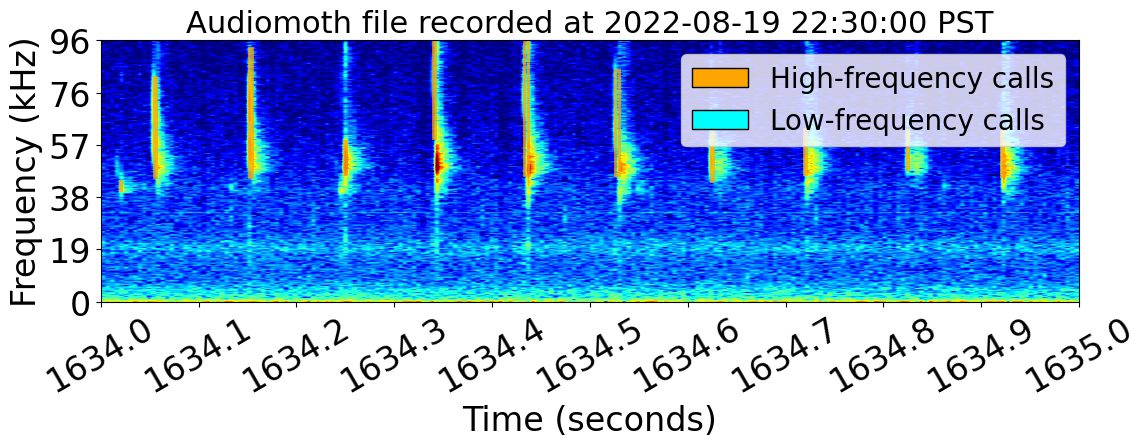

In [81]:
audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration
audio_features['figsize'] = (12, 5)

spec_features = dict()
spec_features['vmax'] = vmax
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

# plot_dets = dc_applied_df.loc[(dc_applied_df['call_start_time']>=file_dt_start)&(dc_applied_df['call_end_time']<=file_dt_end)]
plot_dets = file_dets.loc[(classified_dets & np.logical_and(file_dets['start_time'] >= start, file_dets['end_time'] <= (start+duration)))]
plot_dets_over_audio_seg(audio_features, spec_features, plot_dets, data_params)
audio_file.close()

## Above we see that indeed, Kaleidoscope's detection does not cover the peak frequency for the 4th detection in the clip

## Will there be a permanent fix if I just decrease from 7000 to 8000?

In [100]:
classified_dets = (file_dets['freq_group']!='')
valid_low_freq_inds = file_dets.loc[classified_dets, 'peak_frequency'] > ((file_dets.loc[classified_dets, 'low_freq'])-7000)
valid_low_freq_inds

index_in_file
0       True
1       True
2       True
3       True
4       True
        ... 
1099    True
1100    True
1101    True
1102    True
1103    True
Length: 1103, dtype: bool

In [101]:
file_dets.loc[classified_dets&(~valid_low_freq_inds)][['peak_frequency', 'start_time', 'end_time', 'freq_group', 'low_freq', 'high_freq', 'mean_freq', 'input_file']]

,peak_frequency,start_time,end_time,freq_group,low_freq,high_freq,mean_freq,input_file
index_in_file,,,,,,,,
776,52800.0,1634.339966,1634.341645,HF,60235.508,97560.977,76244.883,/mnt/ubna_data_01_mir/recover-20220822/UBNA_00...


In [97]:
def add_frequency_group_to_file_dets_mod(file_dets, location_classes):
    print(file_dets.name)
    file_classes = location_classes[pd.to_datetime(location_classes['file_name'], 
                                                   format='%Y%m%d_%H%M%S.WAV', exact=False)==file_dets.name].copy()

    file_dets.insert(0, 'index_in_summary', file_dets.index)
    file_dets.set_index('index_in_file', inplace=True)

    classified = file_classes['KMEANS_CLASSES']!=''
    file_classes.loc[classified, 'peak_frequency'] = file_classes.loc[classified, 'peak_frequency'].astype('float64')

    file_dets.insert(0, 'peak_frequency', [np.NaN]*len(file_dets))
    file_dets.loc[file_classes['index_in_file'], 'freq_group'] = file_classes['KMEANS_CLASSES'].values
    file_dets.loc[file_classes['index_in_file'], 'peak_frequency'] = file_classes['peak_frequency'].values

    classified_dets = (file_dets['freq_group']!='')
    assert (file_dets.loc[classified_dets, 'peak_frequency'] > (file_dets.loc[classified_dets, 'low_freq'])-8000).all()
    assert (file_dets.loc[classified_dets, 'peak_frequency'] < (file_dets.loc[classified_dets, 'high_freq'])+8000).all()

    return file_dets

In [98]:
thresh_location_df = init_location_sum.copy()
thresh_location_df.insert(0, 'freq_group', '')
location_classes = pd.read_csv(Path(file_paths['SITE_classes_file']), index_col=0)
thresh_location_df.insert(0, 'input_file_dt', pd.to_datetime(thresh_location_df['input_file'], format='%Y%m%d_%H%M%S.WAV', exact=False))
location_df_grouped = thresh_location_df.groupby('input_file_dt', group_keys=True)

location_df_classified = location_df_grouped.apply(lambda x: add_frequency_group_to_file_dets_mod(x, location_classes))

2022-07-23 04:00:00
2022-07-23 04:30:00
2022-07-23 05:00:00
2022-07-23 05:30:00
2022-07-23 06:00:00
2022-07-23 06:30:00
2022-07-23 07:00:00
2022-07-23 07:30:00
2022-07-23 08:00:00
2022-07-23 08:30:00
2022-07-23 09:00:00
2022-07-23 09:30:00
2022-07-23 10:00:00
2022-07-23 10:30:00
2022-07-23 11:00:00
2022-07-23 11:30:00
2022-07-23 12:00:00
2022-07-24 04:30:00
2022-07-24 05:00:00
2022-07-24 05:30:00
2022-07-24 06:00:00
2022-07-24 06:30:00
2022-07-24 07:00:00
2022-07-24 07:30:00
2022-07-24 08:00:00
2022-07-24 08:30:00
2022-07-24 09:00:00
2022-07-24 09:30:00
2022-07-24 10:00:00
2022-07-24 10:30:00
2022-07-24 11:00:00
2022-07-24 11:30:00
2022-07-24 12:00:00
2022-07-24 13:00:00
2022-07-25 01:30:00
2022-07-25 04:00:00
2022-07-25 04:30:00
2022-07-25 05:00:00
2022-07-25 05:30:00
2022-07-25 06:00:00
2022-07-25 06:30:00
2022-07-25 07:00:00
2022-07-25 07:30:00
2022-07-25 08:00:00
2022-07-25 08:30:00
2022-07-25 09:00:00
2022-07-25 09:30:00
2022-07-25 10:00:00
2022-07-25 10:30:00
2022-07-25 11:00:00


AssertionError: 

## NO, simply decreasing to 8000 does not fix this; needs to be 13000

In [99]:
def add_frequency_group_to_file_dets_mod(file_dets, location_classes):
    print(file_dets.name)
    file_classes = location_classes[pd.to_datetime(location_classes['file_name'], 
                                                   format='%Y%m%d_%H%M%S.WAV', exact=False)==file_dets.name].copy()

    file_dets.insert(0, 'index_in_summary', file_dets.index)
    file_dets.set_index('index_in_file', inplace=True)

    classified = file_classes['KMEANS_CLASSES']!=''
    file_classes.loc[classified, 'peak_frequency'] = file_classes.loc[classified, 'peak_frequency'].astype('float64')

    file_dets.insert(0, 'peak_frequency', [np.NaN]*len(file_dets))
    file_dets.loc[file_classes['index_in_file'], 'freq_group'] = file_classes['KMEANS_CLASSES'].values
    file_dets.loc[file_classes['index_in_file'], 'peak_frequency'] = file_classes['peak_frequency'].values

    classified_dets = (file_dets['freq_group']!='')
    assert (file_dets.loc[classified_dets, 'peak_frequency'] > (file_dets.loc[classified_dets, 'low_freq'])-13000).all()
    assert (file_dets.loc[classified_dets, 'peak_frequency'] < (file_dets.loc[classified_dets, 'high_freq'])+13000).all()

    return file_dets

In [96]:
thresh_location_df = init_location_sum.copy()
thresh_location_df.insert(0, 'freq_group', '')
location_classes = pd.read_csv(Path(file_paths['SITE_classes_file']), index_col=0)
thresh_location_df.insert(0, 'input_file_dt', pd.to_datetime(thresh_location_df['input_file'], format='%Y%m%d_%H%M%S.WAV', exact=False))
location_df_grouped = thresh_location_df.groupby('input_file_dt', group_keys=True)

location_df_classified = location_df_grouped.apply(lambda x: add_frequency_group_to_file_dets_mod(x, location_classes))

2022-07-23 04:00:00
2022-07-23 04:30:00
2022-07-23 05:00:00
2022-07-23 05:30:00
2022-07-23 06:00:00
2022-07-23 06:30:00
2022-07-23 07:00:00
2022-07-23 07:30:00
2022-07-23 08:00:00
2022-07-23 08:30:00
2022-07-23 09:00:00
2022-07-23 09:30:00
2022-07-23 10:00:00
2022-07-23 10:30:00
2022-07-23 11:00:00
2022-07-23 11:30:00
2022-07-23 12:00:00
2022-07-24 04:30:00
2022-07-24 05:00:00
2022-07-24 05:30:00
2022-07-24 06:00:00
2022-07-24 06:30:00
2022-07-24 07:00:00
2022-07-24 07:30:00
2022-07-24 08:00:00
2022-07-24 08:30:00
2022-07-24 09:00:00
2022-07-24 09:30:00
2022-07-24 10:00:00
2022-07-24 10:30:00
2022-07-24 11:00:00
2022-07-24 11:30:00
2022-07-24 12:00:00
2022-07-24 13:00:00
2022-07-25 01:30:00
2022-07-25 04:00:00
2022-07-25 04:30:00
2022-07-25 05:00:00
2022-07-25 05:30:00
2022-07-25 06:00:00
2022-07-25 06:30:00
2022-07-25 07:00:00
2022-07-25 07:30:00
2022-07-25 08:00:00
2022-07-25 08:30:00
2022-07-25 09:00:00
2022-07-25 09:30:00
2022-07-25 10:00:00
2022-07-25 10:30:00
2022-07-25 11:00:00


## Trying a different test based on the median of each group

In [120]:
group = 'HF'
group_classified_dets = (file_dets['freq_group']==group)
assert (file_dets.loc[group_classified_dets, 'peak_frequency'] > (file_dets.loc[group_classified_dets, 'low_freq']).median()-7000).all()
assert (file_dets.loc[group_classified_dets, 'peak_frequency'] < (file_dets.loc[group_classified_dets, 'high_freq']).median()+7000).all()

AssertionError: 

In [170]:
def add_frequency_group_to_file_dets_mod(file_dets, location_classes):
    print(file_dets.name)
    file_classes = location_classes[pd.to_datetime(location_classes['file_name'], 
                                                   format='%Y%m%d_%H%M%S.WAV', exact=False)==file_dets.name].copy()

    file_dets.insert(0, 'index_in_summary', file_dets.index)
    file_dets.set_index('index_in_file', inplace=True)

    classified = file_classes['KMEANS_CLASSES']!=''
    file_classes.loc[classified, 'peak_frequency'] = file_classes.loc[classified, 'peak_frequency'].astype('float64')

    file_dets.insert(0, 'peak_frequency', [np.NaN]*len(file_dets))
    file_dets.loc[file_classes['index_in_file'], 'freq_group'] = file_classes['KMEANS_CLASSES'].values
    file_dets.loc[file_classes['index_in_file'], 'peak_frequency'] = file_classes['peak_frequency'].values
    
    for group in ['LF', 'HF']:
        group_classified_dets = (file_dets['freq_group']==group)
        assert (file_dets.loc[group_classified_dets, 'peak_frequency'] > (file_dets.loc[group_classified_dets, 'low_freq']).median()-7000).all()
        assert (file_dets.loc[group_classified_dets, 'peak_frequency'] > (file_dets.loc[group_classified_dets, 'high_freq']).median()+7000).all()

    return file_dets

In [171]:
thresh_location_df = init_location_sum.copy()
thresh_location_df.insert(0, 'freq_group', '')
location_classes = pd.read_csv(Path(file_paths['SITE_classes_file']), index_col=0)
thresh_location_df.insert(0, 'input_file_dt', pd.to_datetime(thresh_location_df['input_file'], format='%Y%m%d_%H%M%S.WAV', exact=False))
location_df_grouped = thresh_location_df.groupby('input_file_dt', group_keys=True)

location_df_classified = location_df_grouped.apply(lambda x: add_frequency_group_to_file_dets_mod(x, location_classes))

2022-07-23 04:00:00


AssertionError: 

## Trying two optional tests because sometimes the median is too low for peak frequency

In [160]:
group = 'HF'
group_classified_dets = (file_dets['freq_group']==group)

low_assert1 = (file_dets.loc[group_classified_dets, 'peak_frequency'] > (file_dets.loc[group_classified_dets, 'low_freq']).median()-2000)
low_assert2 = (file_dets.loc[group_classified_dets, 'peak_frequency'] > (file_dets.loc[group_classified_dets, 'low_freq'])-2000)

high_assert1 = (file_dets.loc[group_classified_dets, 'peak_frequency'] < (file_dets.loc[group_classified_dets, 'high_freq']).median()+2000)
high_assert2 = (file_dets.loc[group_classified_dets, 'peak_frequency'] < (file_dets.loc[group_classified_dets, 'high_freq'])+2000)

In [162]:
(low_assert1|low_assert2).all()

True

In [163]:
(high_assert1|high_assert2).all()

True

In [175]:
def add_frequency_group_to_file_dets_mod(file_dets, location_classes):
    print(file_dets.name)
    file_classes = location_classes[pd.to_datetime(location_classes['file_name'], 
                                                   format='%Y%m%d_%H%M%S.WAV', exact=False)==file_dets.name].copy()

    file_dets.insert(0, 'index_in_summary', file_dets.index)
    file_dets.set_index('index_in_file', inplace=True)

    classified = file_classes['KMEANS_CLASSES']!=''
    file_classes.loc[classified, 'peak_frequency'] = file_classes.loc[classified, 'peak_frequency'].astype('float64')

    file_dets.insert(0, 'peak_frequency', [np.NaN]*len(file_dets))
    file_dets.loc[file_classes['index_in_file'], 'freq_group'] = file_classes['KMEANS_CLASSES'].values
    file_dets.loc[file_classes['index_in_file'], 'peak_frequency'] = file_classes['peak_frequency'].values
    
    for group in ['LF', 'HF']:
        group_classified_dets = (file_dets['freq_group']==group)

        low_assert1 = (file_dets.loc[group_classified_dets, 'peak_frequency'] > (file_dets.loc[group_classified_dets, 'low_freq']).median()-4000)
        low_assert2 = (file_dets.loc[group_classified_dets, 'peak_frequency'] > (file_dets.loc[group_classified_dets, 'low_freq'])-4000)
        assert(low_assert1|low_assert2).all()
        high_assert1 = (file_dets.loc[group_classified_dets, 'peak_frequency'] < (file_dets.loc[group_classified_dets, 'high_freq']).median()+4000)
        high_assert2 = (file_dets.loc[group_classified_dets, 'peak_frequency'] < (file_dets.loc[group_classified_dets, 'high_freq'])+4000)
        assert(high_assert1|high_assert2).all()

    return file_dets

In [176]:
thresh_location_df = init_location_sum.copy()
thresh_location_df.insert(0, 'freq_group', '')
location_classes = pd.read_csv(Path(file_paths['SITE_classes_file']), index_col=0)
thresh_location_df.insert(0, 'input_file_dt', pd.to_datetime(thresh_location_df['input_file'], format='%Y%m%d_%H%M%S.WAV', exact=False))
location_df_grouped = thresh_location_df.groupby('input_file_dt', group_keys=True)

location_df_classified = location_df_grouped.apply(lambda x: add_frequency_group_to_file_dets_mod(x, location_classes))

2022-07-23 04:00:00
2022-07-23 04:30:00
2022-07-23 05:00:00
2022-07-23 05:30:00
2022-07-23 06:00:00
2022-07-23 06:30:00
2022-07-23 07:00:00
2022-07-23 07:30:00
2022-07-23 08:00:00
2022-07-23 08:30:00
2022-07-23 09:00:00
2022-07-23 09:30:00
2022-07-23 10:00:00
2022-07-23 10:30:00
2022-07-23 11:00:00
2022-07-23 11:30:00
2022-07-23 12:00:00
2022-07-24 04:30:00
2022-07-24 05:00:00
2022-07-24 05:30:00
2022-07-24 06:00:00
2022-07-24 06:30:00
2022-07-24 07:00:00
2022-07-24 07:30:00
2022-07-24 08:00:00
2022-07-24 08:30:00
2022-07-24 09:00:00
2022-07-24 09:30:00
2022-07-24 10:00:00
2022-07-24 10:30:00
2022-07-24 11:00:00
2022-07-24 11:30:00
2022-07-24 12:00:00
2022-07-24 13:00:00
2022-07-25 01:30:00
2022-07-25 04:00:00
2022-07-25 04:30:00
2022-07-25 05:00:00
2022-07-25 05:30:00
2022-07-25 06:00:00
2022-07-25 06:30:00
2022-07-25 07:00:00
2022-07-25 07:30:00
2022-07-25 08:00:00
2022-07-25 08:30:00
2022-07-25 09:00:00
2022-07-25 09:30:00
2022-07-25 10:00:00
2022-07-25 10:30:00
2022-07-25 11:00:00
